#   Comparación entre SARSA Semi-gradiente y Deep Q-Learning

En este notebook solo nos centraremos en la comparativa de los dos algoritmos, sin centrarnos mucho en ellos. En los notebooks de los algoritmos es donde se profundiza en ellos.

## Preparación del entorno
La preparación consta de las siguientes partes:

* **Instalación del Github**: Para hacer uso de clases y herencia, instalamos el repostiroio de github, donde tenemos implementrado todo el código.

* **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.

* **Importación de Librerías**: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.

* **Implantación de semilla**: Para poder replicar los resultados, implantamos una semilla para todos los procesos random implicados.

* **Importación del Entorno CartPole**: Se carga el entorno CartPole.

In [ ]:
import sys

sys.path.append('/content/RL_MC_OL/src')
print(sys.path)

import numpy as np
from tqdm import tqdm
import gymnasium as gym
import random
import torch
import gc
import os

from agentes import SARSASemiGradientAgent, DeepQAgent
from politicas import EpsilonGreedyPolicy
from plotting import plot_training_comparation

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/antonio/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', 'src']


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

seed_value= 100
random.seed(seed_value)
np.random.seed(seed_value)
np.random.default_rng(seed_value) # Establece una instancia del generador de NumPy con la misma semilla

os.environ['PYTHONHASHSEED'] = str(seed_value)
torch.manual_seed(seed_value) 

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed_value) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

Usando dispositivo: cpu


In [3]:
name = 'CartPole-v1'
env = gym.make(name)
env.reset(seed=seed_value)

(array([ 0.03349816,  0.0096554 , -0.02111368, -0.04570484], dtype=float32),
 {})

## Función de entrenamiento

In [4]:
def train_agent(agent, env, episodes=500, max_steps=500):
    """
    Función de entrenamiento basada en episodios.
    Actualiza la barra de progreso con estadísticas resumidas en lugar de imprimir en cada episodio.
    """
    episode_rewards = []
    episode_lengths = []
    
    progress_bar = tqdm(range(episodes), desc="Entrenando episodios", unit="ep")
    
    for ep in progress_bar:
        state, _ = env.reset()
        agent.start_episode()
        total_reward = 0
        
        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.update(state, action, next_state, reward, done, info)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        
        agent.end_episode(total_reward, step + 1)
        episode_rewards.append(total_reward)
        episode_lengths.append(step + 1)
        
        if hasattr(agent.policy, 'decay_epsilon'):
            agent.policy.decay_epsilon()
        
        # Actualiza el progress bar con estadísticas resumidas
        progress_bar.set_postfix({
            "Recompensa": f"{total_reward:.1f}",
            "Pasos": step + 1,
            "Epsilon": f"{agent.policy.epsilon:.4f}"
        })
        
    return episode_rewards, episode_lengths

## Función de evaluación

In [7]:
def evaluate_agent(agent, env, episodes=10, max_steps=500):
    """
    Función de evaluación: ejecuta el agente sin actualizarlo y muestra la recompensa de cada episodio.
    Se fuerza la política greedy (epsilon=0) para evitar exploración durante la evaluación.
    """
    # Guardamos el epsilon actual para restaurarlo después
    old_epsilon = agent.policy.epsilon
    
    # Forzamos la política greedy (sin exploración)
    agent.policy.epsilon = 0.0
    
    total_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for step in range(max_steps):
            action = agent.policy.select_action(state, agent.get_action_values(state))
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        total_rewards.append(total_reward)
        print(f"Episodio de evaluación {ep+1}/{episodes} - Recompensa: {total_reward}")
    
    # Restauramos el epsilon original
    agent.policy.epsilon = old_epsilon
    
    avg_reward = np.mean(total_rewards)
    print(f"Recompensa media en evaluación: {avg_reward:.1f}")
    return total_rewards

## Realizamos el entrenamiento

Entrenamos Deep Q-Learning:


Entrenando episodios: 100%|██████████| 500/500 [02:00<00:00,  4.15ep/s, Recompensa=92.0, Pasos=92, Epsilon=0.0816]  


Episodio de evaluación 1/10 - Recompensa: 500.0
Episodio de evaluación 2/10 - Recompensa: 500.0
Episodio de evaluación 3/10 - Recompensa: 500.0
Episodio de evaluación 4/10 - Recompensa: 500.0
Episodio de evaluación 5/10 - Recompensa: 500.0
Episodio de evaluación 6/10 - Recompensa: 500.0
Episodio de evaluación 7/10 - Recompensa: 500.0
Episodio de evaluación 8/10 - Recompensa: 500.0
Episodio de evaluación 9/10 - Recompensa: 500.0
Episodio de evaluación 10/10 - Recompensa: 500.0
Recompensa media en evaluación: 500.0
Entrenamos SARSA Semi-gradiente:


Entrenando episodios: 100%|██████████| 500/500 [01:31<00:00,  5.46ep/s, Recompensa=500.0, Pasos=500, Epsilon=0.0816]


Episodio de evaluación 1/10 - Recompensa: 500.0
Episodio de evaluación 2/10 - Recompensa: 500.0
Episodio de evaluación 3/10 - Recompensa: 500.0
Episodio de evaluación 4/10 - Recompensa: 500.0
Episodio de evaluación 5/10 - Recompensa: 500.0
Episodio de evaluación 6/10 - Recompensa: 500.0
Episodio de evaluación 7/10 - Recompensa: 500.0
Episodio de evaluación 8/10 - Recompensa: 500.0
Episodio de evaluación 9/10 - Recompensa: 500.0
Episodio de evaluación 10/10 - Recompensa: 500.0
Recompensa media en evaluación: 500.0


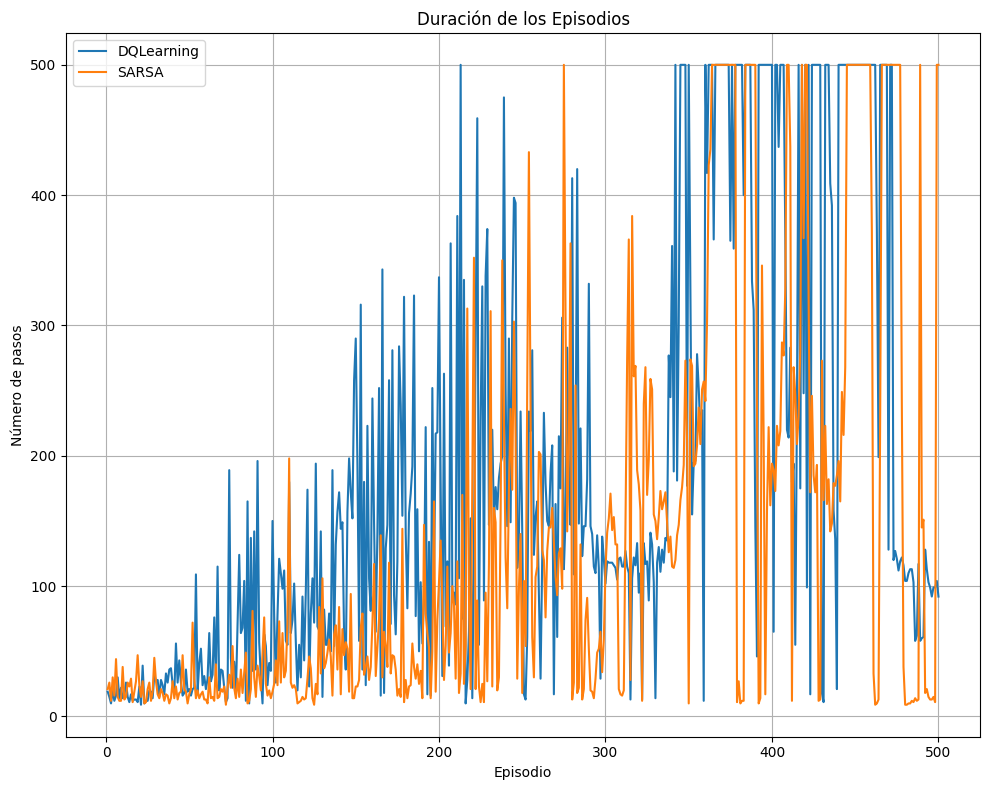

In [9]:
# Definimos los hiperparámetros
episodes = 500
max_steps = 1000
gamma = 0.99
lr= 0.001
epsilon=1.0
epsilon_decay=0.995
epsilon_min=0.01

# Depp Q-Learning
policy = EpsilonGreedyPolicy(env.action_space, epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min)
agentDQ = DeepQAgent(
        env, 
        policy=policy, 
        gamma=gamma, 
        lr=lr, 
        batch_size=32, 
        replay_buffer_size=10000, 
        target_update_freq=100
)
print("Entrenamos Deep Q-Learning:")
episode_rewardsDQ, episode_lengthsDQ = train_agent(agentDQ, env, episodes=episodes, max_steps=max_steps)
evaluate_agent(agentDQ, env, episodes=10, max_steps=max_steps)


#SARSA Semi-gradiente
policy = EpsilonGreedyPolicy(env.action_space, epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min)
agentSARSA = SARSASemiGradientAgent(
        env,
        policy=policy,
        gamma=gamma,
        lr=lr
)
print("Entrenamos SARSA Semi-gradiente:")
episode_rewardsSARSA, episode_lengthsSARSA = train_agent(agentSARSA, env, episodes=episodes, max_steps=max_steps)
evaluate_agent(agentSARSA, env, episodes=10, max_steps=max_steps)



algorithms_data = {
        "DQLearning": (episode_rewardsDQ, episode_lengthsDQ),
        "SARSA": (episode_rewardsSARSA, episode_lengthsSARSA)
}
plot_training_comparation(algorithms_data, same=True)

## Resultados y conclusiones

*   Evolución Durante el Entrenamiento:

    1. Deep Q-Learning (DQN):
        *   En la gráfica se aprecia que el agente empieza con episodios muy cortos y, a lo largo de los 500 episodios, logra numerosos picos de recompensa alta (cercana a 500). No obstante, el último episodio reportado en consola muestra una recompensa de 92 pasos, lo que indica que la política seguía explorando o encontró un estado inicial/desarrollo menos favorable. Aun así, en la evaluación (sin exploración) el desempeño es perfecto (500 pasos).
    2. SARSA Semi-gradiente:
        * Hacia el final del entrenamiento, el agente alcanza y mantiene episodios de 500 pasos de manera más constante. El último episodio de entrenamiento, de hecho, llega a los 500 pasos. Al ser on-policy, SARSA mantiene un nivel de exploración integrado, pero con los hiperparámetros elegido, muestra en este caso una trayectoria final muy estable.

*   Diferencias en la Curva de Aprendizaje

    1. Variabilidad de DQN:
        *   Al ser un método off-policy, DQN puede mostrar altibajos en la curva de entrenamiento debido al replay buffer y la target network.
        *   El último episodio de entrenamiento no siempre refleja el mejor desempeño del agente, ya que todavía hay cierta probabilidad de exploración. Además, la inicialización de cada episodio puede variar, provocando algunos episodios más cortos, incluso tras aprender la estrategia óptima.
    2. Estabilidad de SARSA:
        *   SARSA (semi-gradiente), al final del entrenamiento, se ve muy estable en muchos episodios de 500 pasos. Esto no significa que siempre sea más estable que DQN en general, pero en este experimento particular y con estos hiperparámetros, la política final se mantiene casi siempre en la duración máxima durante los últimos episodios.


Ambas aproximaciones son capaces de aprender la política óptima en CartPole-v1 con los hiperparámetros dados. Las ligeras diferencias en la curva de entrenamiento se deben principalmente a la exploración residual y a la naturaleza on-policy vs. off-policy de cada método. Al final, el desempeño en evaluación es idéntico, demostrando que ambos algoritmos resuelven el entorno de manera óptima.